In [2]:
import numpy as np
import pandas as pd
from scipy import interp
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import gc

from utils import roccin, auc_plot

In [2]:
# Load data from pickle files
train_df = pd.read_pickle('../../data/train.pkl')
test_df = pd.read_pickle('../../data/test.pkl')

#pull out y values
y_train = train_df['isFraud'].copy().to_frame()
X_train = train_df.drop(columns=['isFraud'])


In [3]:
y_train = pd.read_pickle('y_train_features.pkl')
X_train = pd.read_pickle('X_train_features.pkl')
X_test = pd.read_pickle('X_test_features.pkl')

In [3]:
def dedupe_df(df):
    return df.loc[:,~df.columns.duplicated()]
X_train = dedupe_df(X_train)
y_train = dedupe_df(y_train)
test_df = dedupe_df(test_df)

In [4]:
del train_df
gc.collect()

35

In [4]:
#XGBoost model
clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=2,
    tree_method='gpu_hist'
)
'''clf = xgb.XGBClassifier(
    n_estimators=2000,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=2019,
    #gamma = 1,
    tree_method='gpu_hist',
    #eval_method = 'auc',
    #scale_pos_weight = float(1/np.mean(y_train))
)
'''


# Grid Search
param_grid = {'n_estimators':[2000,1000], 
              'learning_rate':[.005,.05]}

clf_grid = GridSearchCV(estimator = clf,
                        param_grid = param_grid,
                       n_jobs = -1,
                       cv=4)

In [ ]:
%%time
gc.collect()
clf_grid.fit(X_train,y_train)

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 0 complete.
Fold 1 complete.


KeyboardInterrupt: 

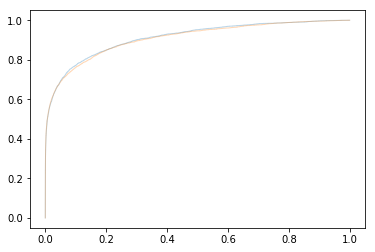

In [8]:
%%time

cv = StratifiedKFold(n_splits=5,shuffle=True)

aucs, test_accuracy_scores, train_accuracy_scores = auc_plot(clf, cv, 
                                                             X_train.drop(['TransactionID','TransactionDT'],axis=1), 
                                                             y_train)

In [ ]:
clf.fit(X_train.drop(['TransactionID','TransactionDT'],axis=1), y_train)
#f_names = X_train.columns
#test_df = test_df[f_names]
y_submit = clf.predict_proba(test_df.drop(['TransactionID','TransactionDT'],axis=1))
print(y_submit)

In [ ]:

write_submission(y_submit, 'xgboost_NAME_DATE')

In [ ]:

save_model(clf,mean_auc)